In [30]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.font_manager
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d  
import seaborn as sns  #A statistical plotting library
from sklearn.cluster import KMeans
from math import comb
from sklearn.preprocessing import PolynomialFeatures
#from kneed import KneeLocator
from mayavi import mlab
plt.style.use('seaborn')
np.random.seed(42)

In [2]:
DF = pd.read_csv('function1_2d.csv')
DF.shape

(2000, 4)

In [3]:
#Defining a class to process and divide the dataframe in to the req. numpy form.
class pro_split_df:
    def __init__(self,df,batch_size):
        self.df   = df                 #The original dataframe.
        self.batch_size = batch_size   #Number of samples to be choosen from the dataframe.
        
        
    #A function to convert dataframe in to numpy array.
    #Training data set input vectors is stored in a matrix of dim Nxd. d -> no. of features, N -> No. of examples
    def df_to_np(self,dat_fr):
        In_df = dat_fr.loc[:,['x1','x2']]    #Choosing the columns belonging to the input feature vectors.
        L_df  = dat_fr.loc[:,['y']]          #Choosing the columns belonging to the labels.
        return In_df.to_numpy(),L_df.to_numpy()
    
    #A function for Random row selection of required batch size of a Pandas dataframe
    def Rand_Choose(self):
        return self.df.sample(n = self.batch_size, random_state=42)
    
    
    def df_split(self,df):
        #Splits the array in to 70,20,10.
        return np.split(df,[int(.7*len(df)), int(.8*len(df))])
    
    #A function to split the batches in to training and data.   
    def tr_val_test_split(self):
        dat_fr = self.Rand_Choose()        #Randomly choosing batchsize number of samples from the org. dataframe.
        tr_df,ts_df,val_df = self.df_split(dat_fr) #Splits the datframe in to train, val and test.
        x_tr,y_tr = self.df_to_np(tr_df)      #conversion to numpy
        x_val,y_val = self.df_to_np(val_df)
        x_test,y_test = self.df_to_np(ts_df)
        return x_tr,x_val,x_test,y_tr,y_val,y_test
        
    

In [43]:
#Dividing the datset in to batches of 50,200 and 500.
#N=50
batch50 = pro_split_df(DF,50)  #An instace of class sep_data.
x_tr50,x_val50,x_test50,y_tr50,y_val50,y_test50 = batch50.tr_val_test_split()

#N=200
batch200 = pro_split_df(DF,200)  #An instace of class sep_data.
x_tr200,x_val200,x_test200,y_tr200,y_val200,y_test200 = batch200.tr_val_test_split()

#N=500
batch500 = pro_split_df(DF,500)  #An instace of class sep_data.
x_tr500,x_val500,x_test500,y_tr500,y_val500,y_test500 = batch500.tr_val_test_split()
#N=2000
batch2000 = pro_split_df(DF,2000)
x_tr2000,x_val2000,x_test2000,y_tr2000,y_val2000,y_test2000 = batch2000.tr_val_test_split()


# fig,(ax1,ax2) = plt.subplots(figsize=(10,8),nrows=2,ncols=1)
# ax1.scatter(x_tr500[:,0],x_tr500[:,1],c='g')
# ax1.set_xlabel('x1')
# ax1.set_ylabel('x2')
# plt.tight_layout()
# plt.show()


In [105]:
#%%writefile Linear_Regression_Class.py 
#Defining a class that given our choice of basis function returns the optimal paramters.
#Polynomial and Gaussian Basis for the regression task at hand is employed.

class Do_Regression:
    #This class will return the optimal paramters by using the basis function of our choice.
    def __init__(self,X,y,Gb_Hp,Pb_Hp,basisname,regularisation):
        self.X = X  #Input vectors of training dataset as a numpy array Nxd.
        self.y = y
        self.Gb_Hp = Gb_Hp
        self.D = None  #An hyperparameter which detrmines the spread of gaussian basis functions.
        self.s = None  #An hyperparameter which detrmines the spread of gaussian basis functions.
        self.Mean_Mat = None     #The mean vector array-(D-1)xd. Each row represents a mean vector.
        self.Pb_Hp = Pb_Hp  #List of hyper
        self.Erms = None
        self.phi = None     #Attribute used to store the design matrix used for testing
        self.pred =None     #Attribute to store the prediction values
        self.basisname = basisname
        self.hp_comb_gbf = None  #An attribute for the combination of hyperparameters.
        self.phi_bar = None 
        self.regularisation = regularisation
           
    #KMeans implementation for finding the mean of the various basis functions initially.
    #Number of clusters eqauls the number of gaussian basis functions being used.
    def K_Clustering(self):
        #Dictionary of the arguments for scikit.KMeans
        KMeans_args = {
        "init" :"random",
        "n_init" : 10,
        "max_iter" : 300,
        "random_state" : 0,
        } 
        k = self.D - 1   #Number of clusters equals D-1.
        kmeans =  KMeans(n_clusters = k , **KMeans_args)
        kmeans.fit(self.X)
        labels = kmeans.labels_
        #The mean vector matrix is stored 
        self.Mean_Mat = kmeans.cluster_centers_
        
        
    def Gaussian_hyperparamter_comb(self):
        hp_list_gbf = list(self.Gb_Hp.values()) # a list of all possible combinations of hyperparameters
        self.hp_comb_gbf = [(d,s) for d in hp_list_gbf[0] for s in hp_list_gbf[1]]    
        
 
    def Gaussian_DesMat(self):
        #Returns the output design matrix made of gbf of the input x.
        phi_gauss = np.zeros((len(self.X), self.D))
        #Finding the mean of clusters,
        self.K_Clustering()   #Calling this function will update the attribute associated with Mean Matrix.
        
        ones_vector = np.ones((len(self.X))) #To be added to the first column of the matrix
        phi_gauss[:,0] = ones_vector
        sigma2 = self.s**2
        expo = ( -2*(self.X@(self.Mean_Mat.T)) + np.reshape(np.sum(self.X**2, axis=1), (len(self.X), -1)) ) + np.sum(self.Mean_Mat**2, axis=1)
        phi_gauss[:,1:] = np.exp(-expo/sigma2)
        return phi_gauss
    
    def GaussDM_test_Data(self):
        #Returns the output design matrix made of gbf of the input x of test data.
        phi_gauss = np.zeros((len(self.X), self.D))
        ones_vector = np.ones((len(self.X))) #To be added to the first column of the matrix
        phi_gauss[:,0] = ones_vector
        sigma2 = self.s**2
        expo = ( -2*(self.X@(self.Mean_Mat.T)) + np.reshape(np.sum(self.X**2, axis=1), (len(self.X), -1)) ) + np.sum(self.Mean_Mat**2, axis=1)
        phi_gauss[:,1:] = np.exp(-expo/sigma2)
        return phi_gauss
        
       
    
    def Poly_DesMat(self):
        #Returns the output design matrix made of gbf of the input x and degree m.
        d = len(x[0])
        #m is the maximum degree of monomials being used for polynomial basis function.
        poly = PolynomialFeatures(degree = self.m)  #Using the inbuilt function from sklearn.
        phi_poly = poly.fit_transform(self.X)
        
        
        #Plotting for better understanding
#         phi_flat = phi_poly.flatten()
#         xarr = np.arange(1,phi_flat.size+1,1)
#         plt.scatter(xarr,phi_flat)
#         plt.show()
        return phi_poly
    
    def get_design_mat(self):
        if self.basisname == 'Gaussian':
            PHI = self.Gaussian_DesMat()   #Updates the design matrix with gaussian basis functions.
        if self.basisname == 'Polynomial':
            PHI = self.Poly_DesMat()        #Updates the design matrix with polynomial basis functions.
#         if basisname == 'Linear':
#             PHI = self.X
        return PHI 
    
    def Reg_term(self,MU):
        deg = self.D-1
        sigma2 = self.s**2
        self.phi_bar = np.eye(self.D)   #For Quadratic regualriser.
        if self.regularisation == 'Tikhonov':
            for i in range(deg):
                for j in range(i):
                    self.phi_bar[i+1][j+1] = np.exp(-np.sum((MU[j]-MU[i])**2)/sigma2)
                    self.phi_bar[j+1][i+1] = self.phi_bar[i+1][j+1]
#             expo = np.reshape(np.sum(MU**2,axis=1),(len(MU),-1)) + np.sum(MU**2,axis=1) - 2*(MU@MU.T)
#             self.phi_bar = np.exp(-expo/2*self.s*self.s)
        
        
        
    
    def LinearRegressor(self,lam):  
        #Takes as input the labels of the training data and the hyperparamter lambda
        erms_tr ={}
        W = {}
        MU ={}
        if self.basisname == 'Gaussian':
            self.Gaussian_hyperparamter_comb()  #Updates the attribute for the combination of hyperparameters.
            for (dim,sigma) in self.hp_comb_gbf:
                self.D,self.s = dim,sigma        #Updates the attribute for hyperparameters of gbf
                PHI = self.get_design_mat()
                MU[str(dim)+' '+ str(sigma)] = self.Mean_Mat
                self.Reg_term(self.Mean_Mat)                  #Updates the attribute self.phi_bar
                w = LA.inv(PHI.T@PHI + lam*self.phi_bar)@(PHI.T@self.y)
                #Error for training data
                erms_tr[str(dim)+' '+ str(sigma)] = self.erms(w,0)
                W[str(dim)+ ' ' + str(sigma)] = w
            
        if self.basisname == 'Polynomial':
            for degree in Pb_Hp:
                self.m = degree
                PHI = self.get_design_mat()
                self.Reg_term()   #Updates the attribute self.phi_bar
                w = np.linalg.inv(PHI.T@PHI + lam*self.phi_bar)@(PHI.T@self.y)
                W['degree'] = w
        return W,MU,erms_tr
    
    
    def erms(self,w,f):
        if f==1:  #for testing
            self.phi = self.GaussDM_test_Data()
        if f==0:  #For training
            self.phi = self.get_design_mat()
        self.pred = self.phi@w
        error_arr = (self.pred - self.y)
        #plt.scatter(self.y,self.pred,c='g')
        return LA.norm(error_arr)/np.sqrt(len(self.y))
#     
    
    
    def test_set_error(self,W,MU):  #W is the optimal parameters estimated from training
        #Run this function only after training and on testing on validation and test dataset.
        erms_test = {}
        self.Gaussian_hyperparamter_comb()
        for (dim,sigma) in self.hp_comb_gbf:
            self.D,self.s = dim,sigma
            w = W[str(dim)+' '+ str(sigma)]
            mu = MU[str(dim)+' '+ str(sigma)]
            self.Mean_Mat = mu
            erms_test[str(dim)+' '+ str(sigma)] = self.erms(w,1)
        return erms_test
    
    def plot_pred_vs_true(self,w,mu,sig):
        true_val = self.y
        self.s = sig
        self.D = len(w)
        self.Mean_Mat = mu
        phi = self.GaussDM_test_Data()
        pred = phi@w
        fig,ax = plt.subplots(figsize=(8,6))
        ax.scatter(true_val,pred,c='b')
        ax.set_xlabel('true value')
        ax.set_ylabel('predicted value')
        ax.set_title('Plot for True Value vs Predicted Value of the best model for test dataset with E_rms = 134.45')
        plt.show()

        

In [106]:
#Hyperparamters for gaussian and polynomial.
Gb_Hp = {'Dim': [25,50,75,100,340], 'sigma' : [1,10,50]}
Pb_Hp = [2,3,6,9] 
#An instance of the class regression for training.
do_reg = Do_Regression(x_tr500,y_tr500,Gb_Hp,Pb_Hp,'Gaussian','Quadratic')  #An instance for the regression class.


In [107]:
#Optimal Parameters, mean and error as a dic, estimated using 
#training data of batch 500 and lambda = 0 using gbf.
#Model is being trained with no regularisation.
W_opt,MU_opt,erms_tr_data = do_reg.LinearRegressor(0) 


In [108]:
erms_tr_data

{'25 1': 34095.494686217564,
 '25 10': 3079.371660135906,
 '25 50': 196543.08688426978,
 '50 1': 27069.058398069203,
 '50 10': 333.07885206654373,
 '50 50': 701035.3979131614,
 '75 1': 22878.4620354193,
 '75 10': 118.92448616707225,
 '75 50': 384949.9066247332,
 '100 1': 18762.38702030317,
 '100 10': 361624.2434747671,
 '100 50': 722691.0098886471,
 '340 1': 1007.1582536619655,
 '340 10': 2748197.8587605567,
 '340 50': 522712.22354947234}

In [109]:
#Validation dataset error estimation for finding the optimal values of hyperparameters.
val_reg = Do_Regression(x_val500,y_val500,Gb_Hp,Pb_Hp,'Gaussian','Quadratic')
erms_val_data = val_reg.test_set_error(W_opt,MU_opt)
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_val_data

{'25 1': 64240.92286294608,
 '25 10': 4120.376944837653,
 '25 50': 201337.65009581094,
 '50 1': 43948.50916755136,
 '50 10': 487.78710378390804,
 '50 50': 686256.7398583073,
 '75 1': 35610.43065848766,
 '75 10': 147.3034244802795,
 '75 50': 394207.89239694976,
 '100 1': 33902.31040040158,
 '100 10': 351136.37994587293,
 '100 50': 709933.1032306574,
 '340 1': 25161.390393252586,
 '340 10': 3301376.465094139,
 '340 50': 529384.4123755863}

In [96]:
mu_plot.shape

(74, 2)

### Dimension = 75 and sigma = 10 is found to be the best model. Overfitting studies are being done on Dimension = 340 and sigma =1 as the error varies significantly for training and validation.

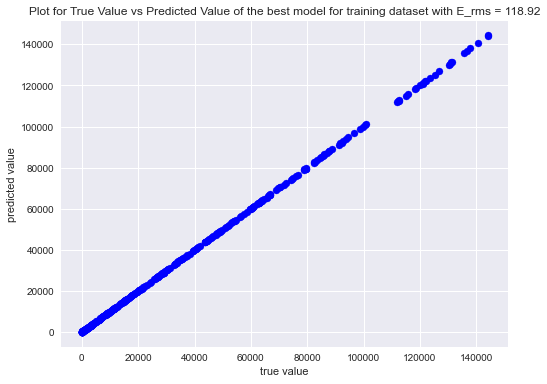

<Figure size 576x396 with 0 Axes>

In [90]:
#The parameters of the best model that needs plotting.
w_plot = W_opt['75 10']
mu_plot = MU_opt['75 10']

#Plotting true vs prediction for training dataset without regularization.
do_reg.plot_pred_vs_true(w_plot,mu_plot,10)
plt.savefig('batch500_train.png', dpi=300, bbox_inches='tight')

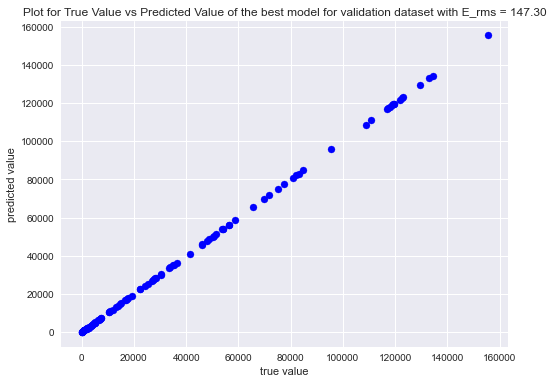

<Figure size 576x396 with 0 Axes>

In [98]:
val_reg.plot_pred_vs_true(w_plot,mu_plot,10)

In [110]:
#Test dataset error estimation.
test_reg = Do_Regression(x_test500,y_test500,Gb_Hp,Pb_Hp,'Gaussian','Quadratic')
erms_test_data = test_reg.test_set_error(W_opt,MU_opt)
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_test_data

{'25 1': 41614.001550152825,
 '25 10': 3173.288741883285,
 '25 50': 208046.17375158335,
 '50 1': 55065.030882193605,
 '50 10': 446.7785690636309,
 '50 50': 672826.5861592834,
 '75 1': 47958.67442382631,
 '75 10': 134.45128353056708,
 '75 50': 405546.52013881016,
 '100 1': 36547.27704069934,
 '100 10': 371242.19411755144,
 '100 50': 703451.8510677284,
 '340 1': 19797.07054725882,
 '340 10': 3414949.9662941615,
 '340 50': 532962.5960586105}

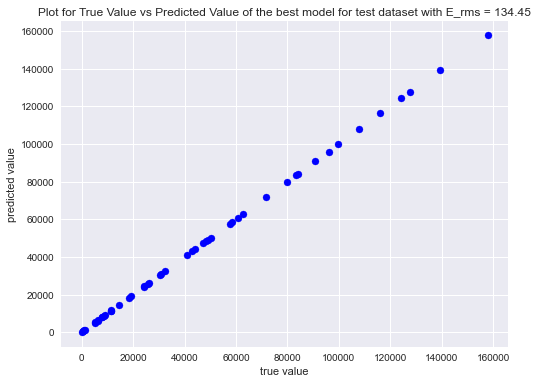

In [111]:
test_reg.plot_pred_vs_true(w_plot,mu_plot,10)

In [112]:
#Effect of quadratic regularisation on dimesnsion 100 and sigma =1
#Fitting the training datasets
Gb_Hp_reg = {'dim':[340],'sigma':[1]}
regl_tr_reg = Do_Regression(x_tr500,y_tr500,Gb_Hp_reg,Pb_Hp,'Gaussian','Quadratic')
lam_lst = [10e-07,10e-05,10e-03,10e-01,0,10,10e+3,10e+5]
W_opt_reg ={}
MU_opt_reg ={}
erms_tr_reg ={}
for lam in lam_lst:
    W_opt_reg[str(lam)],MU_opt_reg[str(lam)],erms_tr_reg[str(lam)] = regl_tr_reg.LinearRegressor(lam) 
erms_tr_reg

{'1e-06': {'340 1': 1007.2510929437628},
 '0.0001': {'340 1': 1008.8371850745775},
 '0.01': {'340 1': 1173.2543730474981},
 '1.0': {'340 1': 11540.374635193548},
 '0': {'340 1': 1007.1582536619655},
 '10': {'340 1': 28496.70956110311},
 '10000.0': {'340 1': 51184.98985586116},
 '1000000.0': {'340 1': 52047.190616761225}}

In [113]:
#Validation dataset error estimation for varying lambda
regl_val_reg = Do_Regression(x_val500,y_val500,Gb_Hp_reg,Pb_Hp,'Gaussian','Quadratic')
erms_val_qreg={}
for lam in lam_lst:
    erms_val_qreg[str(lam)] = regl_val_reg.test_set_error(W_opt_reg[str(lam)],MU_opt_reg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_val_qreg

{'1e-06': {'340 1': 25170.149316570787},
 '0.0001': {'340 1': 25204.514576970752},
 '0.01': {'340 1': 25298.833579924107},
 '1.0': {'340 1': 29591.115329467204},
 '0': {'340 1': 25161.390393252586},
 '10': {'340 1': 38521.82204173064},
 '10000.0': {'340 1': 59196.6600493052},
 '1000000.0': {'340 1': 60057.041078228875}}

In [114]:
#Validation dataset error estimation for varying lambda
regl_test_reg = Do_Regression(x_test500,y_test500,Gb_Hp_reg,Pb_Hp,'Gaussian','Quadratic')
erms_test_qreg={}
for lam in lam_lst:
    erms_test_qreg[str(lam)] = regl_test_reg.test_set_error(W_opt_reg[str(lam)],MU_opt_reg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_test_qreg

{'1e-06': {'340 1': 19790.77163341803},
 '0.0001': {'340 1': 19747.409990274005},
 '0.01': {'340 1': 19830.619547854283},
 '1.0': {'340 1': 26288.85846129357},
 '0': {'340 1': 19797.07054725882},
 '10': {'340 1': 37822.33871629556},
 '10000.0': {'340 1': 60804.30029816793},
 '1000000.0': {'340 1': 61707.628641813775}}

In [115]:
#Effect of Tikhonov regularisation on dimesnsion 100 and sigma =1
tregl_tr_reg = Do_Regression(x_tr500,y_tr500,Gb_Hp_reg,Pb_Hp,'Gaussian','Tikhonov')
lam_lst = [10e-07,10e-05,10e-03,10e-01,0,10,10e+1,10e+3,10e+5]
W_opt_treg ={}
MU_opt_treg ={}
erms_tr_treg ={}
for lam in lam_lst:
    W_opt_treg[str(lam)],MU_opt_treg[str(lam)],erms_tr_treg[str(lam)] = tregl_tr_reg.LinearRegressor(lam) 
erms_tr_treg

{'1e-06': {'340 1': 1007.1582909220164},
 '0.0001': {'340 1': 1007.3876906520843},
 '0.01': {'340 1': 1046.360813998784},
 '1.0': {'340 1': 14205.18953262106},
 '0': {'340 1': 1007.1582536619655},
 '10': {'340 1': 31613.720387947735},
 '100.0': {'340 1': 37413.07491945173},
 '10000.0': {'340 1': 51192.84533600013},
 '1000000.0': {'340 1': 52047.272258910394}}

In [116]:
#Validation dataset error estimation for varying lambda
tik_regl_val_reg = Do_Regression(x_val500,y_val500,Gb_Hp_reg,Pb_Hp,'Gaussian','Tikhonov')
erms_val_treg={}
for lam in lam_lst:
    erms_val_treg[str(lam)] = tik_regl_val_reg.test_set_error(W_opt_treg[str(lam)],MU_opt_treg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_val_treg

{'1e-06': {'340 1': 25161.153961318283},
 '0.0001': {'340 1': 25157.006580912905},
 '0.01': {'340 1': 25431.929262863356},
 '1.0': {'340 1': 30882.727421515378},
 '0': {'340 1': 25161.390393252586},
 '10': {'340 1': 40104.34212028504},
 '100.0': {'340 1': 44542.45848712857},
 '10000.0': {'340 1': 59200.74873625448},
 '1000000.0': {'340 1': 60057.08405728594}}

In [117]:
#Validation dataset error estimation for varying lambda
tik_regl_test_reg = Do_Regression(x_test500,y_test500,Gb_Hp_reg,Pb_Hp,'Gaussian','Tikhonov')
erms_test_treg={}
for lam in lam_lst:
    erms_test_treg[str(lam)] = tik_regl_test_reg.test_set_error(W_opt_treg[str(lam)],MU_opt_treg[str(lam)])
# erms_val_df = pd.DataFrame(list(erms_val_data.items()),columns = ['Degree and Sigma','Erms'])
erms_test_treg

{'1e-06': {'340 1': 19795.775133363633},
 '0.0001': {'340 1': 19708.056416923573},
 '0.01': {'340 1': 19708.858577334042},
 '1.0': {'340 1': 27630.92906760994},
 '0': {'340 1': 19797.07054725882},
 '10': {'340 1': 39308.62094735066},
 '100.0': {'340 1': 44656.90076074999},
 '10000.0': {'340 1': 60807.39548320332},
 '1000000.0': {'340 1': 61707.66171510584}}